# 1-Layer SW Jet Stability in Firdrake #


<b> Strong Form: </b>

\begin{align*}
c \, \hat u 
& = \overline u \hat u
+ (\partial_y \overline u - \frac{1}{Ro}) \hat v + \frac{1}{Ro} \hat \eta, \\
c \, \hat v 
& = - \frac{1}{Ro k^2} \hat u + \overline u \hat v - \frac{1}{Ro k^2} \partial_y \hat \eta, \\
 c  \, \hat \eta & =  \frac{1}{Ro Bu} \overline h \hat u +  \frac{1}{Ro Bu} \partial_y ( \overline h \hat v ) + \overline u  \hat \eta.
\end{align*}

<b> Weak Form: </b>

\begin{align*}
c \int_A \left[ \phi \hat u + \psi  \hat v + \varphi \hat \eta \right] \, dA
& = \int_A \left( \overline u  \phi  - \frac{1}{Ro k^2} \psi  
+ \frac{1}{Ro} \overline h \varphi  \right)  \hat u \, dA \\
& = \int_A \left( (\partial_y \overline u - \frac{1}{Ro}) \phi  +  \overline u \psi  - \frac{1}{Ro} \overline h \partial_y  \varphi  \right) \hat v \, dA \\
& = \int_A \left( \frac{1}{Ro} \phi - \frac{1}{Ro k^2} \psi \partial_y  + \varphi \overline u   \right) \hat \eta \, dA \\
\end{align*}

In [1]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from firedrake import *
from firedrake.petsc import PETSc
try:
    from slepc4py import SLEPc
except ImportError:
    import sys
    warning("Unable to import SLEPc, eigenvalue computation not possible (try firedrake-update --slepc)")
    sys.exit(0)

In [2]:
# Define an Interval Mesh

Ly   = 20.0
Uj   = 0.5
n0   = 100
mesh = IntervalMesh(n0, Ly)
x = SpatialCoordinate(mesh)

# Define parameters

beta = Constant('0.0')
Bu   = Constant('0.0004')
Ro   = Constant('0.25')

# Profile

profile = 'bickley'
#profile = 'gaussian'
#profile = 'bump'

In [3]:
# Print parameters

print('Ro      = ', float(Ro))
print('Bu      = ', float(Bu))
print('profile = ', profile)

('Ro      = ', 0.25)
('Bu      = ', 0.0004)
('profile = ', 'bickley')


In [4]:
# Order of the Method

p = 0 # Define CG function space

# Function Spaces
V  = FunctionSpace(mesh,'CG',p+2)
Z  = V*V*V

# Impose zero Dirichlet BCs
bc = DirichletBC(Z.sub(1), 0.0, "on_boundary")

# Define modes 

em_real,  em_imag  = Function(Z), Function(Z)
u_real,   u_imag   = Function(V), Function(V)
v_real,   v_imag   = Function(V), Function(V)
eta_real, eta_imag = Function(V), Function(V)

In [5]:
# TEST/TRIAL FUNCTIONS
(u, v, eta)      = TrialFunctions(Z)
(phi, psi, vphi) = TestFunctions(Z)

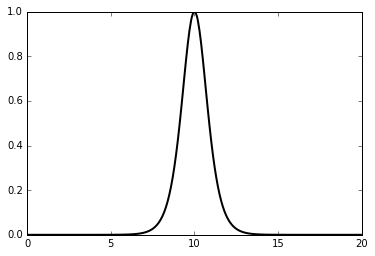

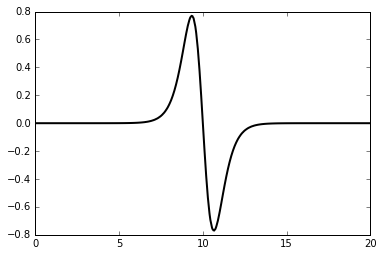

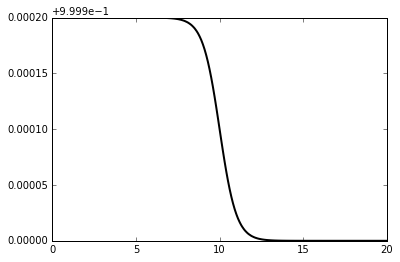

In [6]:
# Define Basic State

Ub  = Function(V).interpolate(1./pow(cosh(x[0]-Ly/2),2))
dUb = Function(V).interpolate(-2.*sinh(x[0]-Ly/2)/pow(cosh(x[0]-Ly/2),3))    # FJP: compute correctly
Eb  = Function(V).interpolate(-tanh(x[0]-Ly/2))             # FJP: remove?
Hb  = Function(V).interpolate(1. + Ro*Bu*Eb)

plot(Ub)
plt.show()
plot(dUb)
plt.show()
plot(Hb)
plt.show()

In [9]:
num_eigenvalues = 4

# Wavenumber
dkk = 5e-2
kk = np.arange(0.5 - dkk,.5,dkk)
#dk   = 0.05
#kk   = np.arange(dk, 2., dk)
kL   = len(kk)
egs_re  = np.zeros((len(kk),num_eigenvalues))
egs_im  = np.zeros((len(kk),num_eigenvalues))

cnt = 0
for k in kk:

    k2   = Constant(k**2)

    # Define Weak form
    
    a =   ( (  Ub*phi           - psi/(Ro*k2)           + Hb/(Ro*Bu)*vphi)*u )*dx \
        + ( ( (dUb - 1./Ro)*phi + Ub*psi                - Hb/(Ro*Bu)*vphi.dx(0) )*v )*dx \
        + (    phi*eta/Ro       - psi*eta.dx(0)/(Ro*k2) + Ub*vphi*eta )*dx           
    m =       (phi*u + psi*v + vphi*eta)*dx
    
    # Build Petsc operators
    
    petsc_a = assemble(a, mat_type='aij', bcs=bc).M.handle
    petsc_m = assemble(m, mat_type='aij', bcs=bc).M.handle

    # Define Petsc options

    opts = PETSc.Options()
    opts.setValue("eps_gen_non_hermitian", None)
    opts.setValue("st_pc_factor_shift_type", "NONZERO")
    #opts.setValue("eps_type", "lapack")
    opts.setValue("eps_type", "krylovschur")
    opts.setValue("eps_largest_imaginary", None)
    opts.setValue("eps_tol", 1e-10)

    # Define Solver options

    es = SLEPc.EPS().create(comm=COMM_WORLD)
    es.setDimensions(num_eigenvalues)
    es.setOperators(petsc_a, petsc_m)
    es.setFromOptions()
    es.solve()

    # Additionally we can find the number of converged eigenvalues. ::

    nconv = es.getConverged()
    imax = min(nconv, num_eigenvalues)
    
    for i in range(imax):
        with em_real.dat.vec as vr:
            with em_imag.dat.vec as vi:
                lam = es.getEigenpair(i, vr, vi)
                #print ("Iteration #: "), i, ("| Real Eigenfrequency: "), lam.real, ("| Imag Eigenfrequency: "), lam.imag

                egs_re[cnt,i] = k*lam.real
                egs_im[cnt,i] = k*lam.imag

                u_real, v_real, eta_real = em_real.split()
                u_imag, v_imag, eta_imag = em_imag.split()
    
    ## Find eigenfunctions
    #emodes_real.vector()[:], emodes_imag.vector()[:] = vr, vi
    #print "Leading eigenvalue is:", lam, " for cnt = ", cnt, " with nconv = ", nconv
    print k, egs_im[cnt,0]
    cnt += 1
    
print np.max(abs(egs_im))

0.45 0.0
0.0


0.136224481223
0.115912563637


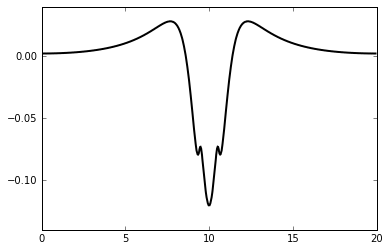

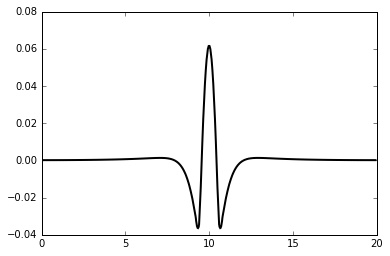

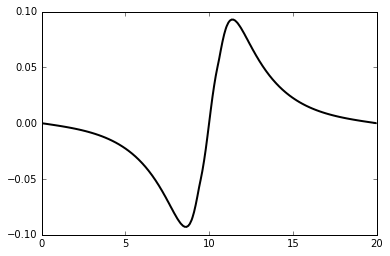

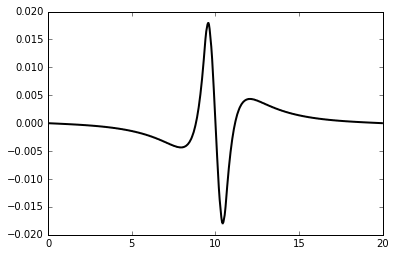

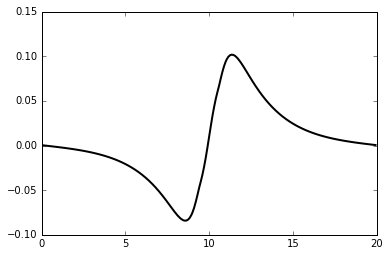

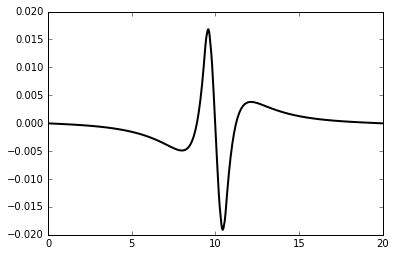

In [8]:
plot(u_real)
plot(u_imag)
plot(v_real)
plot(v_imag)
plot(eta_real)
plot(eta_imag)

print egs_re[0,0]
print egs_im[0,0]

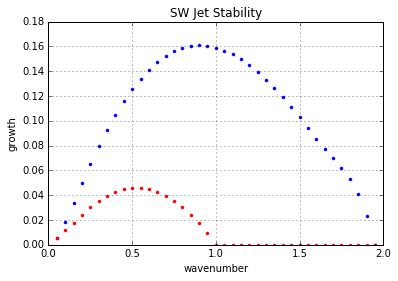

bickley
0.160733765478 0.0459076142168


In [93]:
plt.plot(kk,egs_im[:,0],'.b',linewidth=2,label='symmetric')
plt.plot(kk,egs_im[:,2],'.r',linewidth=2,label='antisymmetric')
plt.grid('on')
plt.xlabel('wavenumber')
plt.ylabel('growth')
#plt.title('Growth Rates of Jet: 1LQG')
plt.title('SW Jet Stability')
#plt.xlim([4.7,5.0])
#plt.savefig("figure_bump.png")
plt.show()
print profile
print np.max(egs_im[:,0]), np.max(egs_im[:,2])

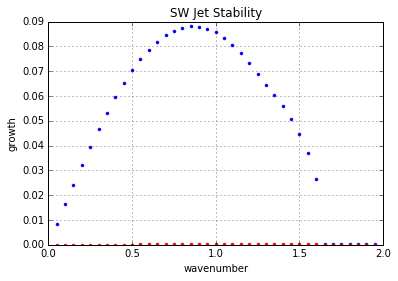

bickley
0.0880953593987 0.000306383162068


In [19]:
plt.plot(kk,egs_im[:,0],'.b',linewidth=2,label='symmetric')
plt.plot(kk,egs_im[:,2],'.r',linewidth=2,label='antisymmetric')
plt.grid('on')
plt.xlabel('wavenumber')
plt.ylabel('growth')
#plt.title('Growth Rates of Jet: 1LQG')
plt.title('SW Jet Stability')
#plt.xlim([4.7,5.0])
#plt.savefig("figure_bump.png")
plt.show()
print profile
print np.max(egs_im[:,0]), np.max(egs_im[:,2])

In [21]:
print float(Ro), float(Bu)

0.25 0.0004


In [70]:
print 0.0871562930508*2

0.174312586102
